# Airline Reliability
This notebook is using the airline delay causes dataset from Kaggle, https://www.kaggle.com/giovamata/airlinedelaycauses.

The analysis of this data will aim to anser the following questions:

1. Which day of the week is the worst day for flight delays?

2. Is there a period throughout the year where delays are higher than average?

3. Which flights, departure and destination locations, are the most delayed?

4. Which airline is the most reliable?

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./source/DelayedFlights.csv', index_col=0)                
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


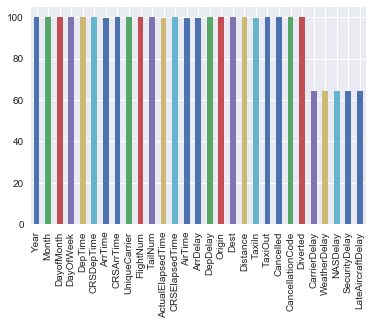

In [201]:
((df.count() / df.shape[0]) * 100).plot(kind="bar");

We are only interested in rows where there is a reported delay. As can be seen above this is in approximately 60% of the datset. 
The cells with Nan reported for all delay fields are dropped.

In [202]:
df = df.dropna(subset=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])

In [203]:
df.count() / df.shape[0]

Year                 1.000000
Month                1.000000
DayofMonth           1.000000
DayOfWeek            1.000000
DepTime              1.000000
CRSDepTime           1.000000
ArrTime              1.000000
CRSArrTime           1.000000
UniqueCarrier        1.000000
FlightNum            1.000000
TailNum              0.999998
ActualElapsedTime    1.000000
CRSElapsedTime       1.000000
AirTime              1.000000
ArrDelay             1.000000
DepDelay             1.000000
Origin               1.000000
Dest                 1.000000
Distance             1.000000
TaxiIn               1.000000
TaxiOut              1.000000
Cancelled            1.000000
CancellationCode     1.000000
Diverted             1.000000
CarrierDelay         1.000000
WeatherDelay         1.000000
NASDelay             1.000000
SecurityDelay        1.000000
LateAircraftDelay    1.000000
dtype: float64

As can be seen above the cells with nan in a delay field are dropped, all fields now have 100% data compared to other fields.

In [204]:
object_data = set(df.select_dtypes(include=['object']).columns)

In [205]:
for col in object_data:
    print(df[col].value_counts().head(), '\n')

ORD    79626
ATL    71607
DFW    45964
EWR    40873
DEN    38613
Name: Dest, dtype: int64 

WN    203559
AA    132257
MQ     97555
UA     95465
OO     88991
Name: UniqueCarrier, dtype: int64 

N17175    686
N77278    679
N87353    678
N37208    665
N37342    660
Name: TailNum, dtype: int64 

ORD    90611
ATL    87741
DFW    62073
DEN    46477
EWR    36115
Name: Origin, dtype: int64 

N    1247488
Name: CancellationCode, dtype: int64 



Above are samples of the object types within the dataset.

<b> Dest & Origin </b>
These two columns will need to be converted, they will be used for indicating the routes with the most delay.

<b> Unique Carrier </b> 
This data will need to be converted, it is used to identify the airlines.

<b> TailNum </b>
This data identifies specific planes, this is not required for the questions posed and will be dropped.

<b> CancellationCode </b>
This data will be dropped as no cancelled flights have been recorded. 

In [206]:
df = df.drop('CancellationCode', axis=1)

In [207]:
df = df.drop('TailNum', axis=1)

In [208]:
df['Route'] = df['Origin'] + " - " + df['Dest']

In [209]:
df = df.drop(['Dest','Origin'], axis=1)

In [210]:
print("Unique Routes:",df['Route'].value_counts().count())

Unique Routes: 5086


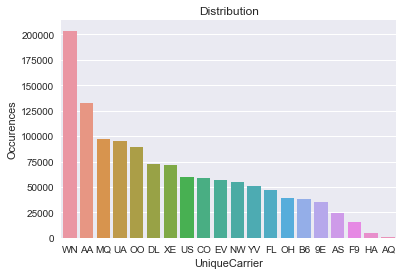

In [211]:
uniqueCarriersCount = df['UniqueCarrier'].value_counts()
sns.set(style="darkgrid")
sns.barplot(uniqueCarriersCount.index, uniqueCarriersCount.values)
plt.title('Distribution')
plt.ylabel('Occurences')
plt.xlabel('UniqueCarrier')
plt.show()

Investigating the airline carrier data it can be seen that there is a large variance in the number of flights. No columns will be dropped as the large variance could be due to business size, number of planes or number of customers requireing flights. 

The next step is to encode the airlines, a label encoder will be used here. 

In [222]:
uniqueCarrierDict = dict(enumerate(df['UniqueCarrier'].astype('category').cat.categories))

In [224]:
df['UniqueCarrier'] = df['UniqueCarrier'].astype('category').cat.codes

A dictionary containing the mapping to be applied is generated and then the UniqueCarrier field is encoded and values updated. 

The same process is repeated for the Route field that was generated earlier.

In [229]:
uniqueRouteDict = dict(enumerate(df['Route'].astype('category').cat.categories))

In [230]:
df['Route'] = df['Route'].astype('category').cat.codes

In [235]:
# df['Route'].map(uniqueRouteDict), this will map the dictionary back to the initial values.

## Days of the week

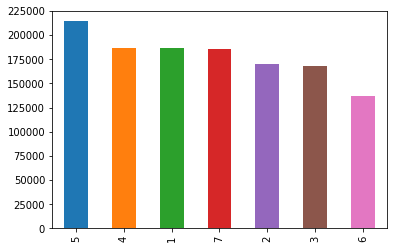

In [156]:
df['DayOfWeek'].value_counts()
(df['DayOfWeek'].value_counts()).plot(kind="bar");

The above chart shows the day of the week for flights, 1 = Monday, 7 = Sunday.
The most popular day of the week to travel on is Friday and Saturday being the least popular.
Every other day is in a median range.

In [157]:
delay_by_day = (df.groupby('DayOfWeek', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

In [158]:
delay_by_day

,DayOfWeek,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,19.376672,3.346693,14.476062,0.079685,25.472937
1,2,18.367989,4.120911,17.078724,0.076329,25.412248
2,3,19.213996,3.387808,14.709697,0.087040,23.642793
3,4,18.360238,3.647854,14.624468,0.083608,24.631885
4,5,17.795664,3.580344,15.478843,0.085355,26.493645
5,6,22.038966,3.990661,12.518273,0.146978,23.456511
6,7,20.009450,3.953517,15.687468,0.086309,27.153928


In [159]:
delay_by_day['TotalDelay'] = delay_by_day['CarrierDelay'] + delay_by_day['WeatherDelay'] + delay_by_day['NASDelay'] + delay_by_day['SecurityDelay'] + delay_by_day['LateAircraftDelay']
delay_by_day.sort_values(by='TotalDelay')

,DayOfWeek,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay
2,3,19.213996,3.387808,14.709697,0.087040,23.642793,61.041335
3,4,18.360238,3.647854,14.624468,0.083608,24.631885,61.348052
5,6,22.038966,3.990661,12.518273,0.146978,23.456511,62.151388
0,1,19.376672,3.346693,14.476062,0.079685,25.472937,62.752050
4,5,17.795664,3.580344,15.478843,0.085355,26.493645,63.433851
1,2,18.367989,4.120911,17.078724,0.076329,25.412248,65.056200
6,7,20.009450,3.953517,15.687468,0.086309,27.153928,66.890671


## Months of the year

In [160]:
delay_by_month = (df.groupby('Month', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

In [161]:
delay_by_month

,Month,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,19.354470,3.530053,14.407299,0.102711,25.652600
1,2,18.507422,4.207895,14.532052,0.086024,26.837397
2,3,19.188412,3.610672,13.664191,0.111840,25.506481
3,4,19.657297,2.748136,13.616508,0.077583,23.315056
4,5,18.068723,2.523910,14.009781,0.102340,23.666948
5,6,18.124587,4.179695,17.568216,0.077266,26.217786
6,7,20.168679,4.648513,17.511306,0.109670,25.643061
7,8,21.107413,3.961263,14.723465,0.073378,24.746705
8,9,21.715276,2.807024,14.169841,0.085064,19.037111
9,10,19.950980,1.836139,12.343436,0.090892,20.119834


In [162]:
delay_by_month['TotalDelay'] = delay_by_month['CarrierDelay'] + delay_by_month['WeatherDelay'] + delay_by_month['NASDelay'] + delay_by_month['SecurityDelay'] + delay_by_month['LateAircraftDelay']
delay_by_month.sort_values(by='Month')

,Month,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay
0,1,19.354470,3.530053,14.407299,0.102711,25.652600,63.047133
1,2,18.507422,4.207895,14.532052,0.086024,26.837397,64.170790
2,3,19.188412,3.610672,13.664191,0.111840,25.506481,62.081595
3,4,19.657297,2.748136,13.616508,0.077583,23.315056,59.414580
4,5,18.068723,2.523910,14.009781,0.102340,23.666948,58.371703
5,6,18.124587,4.179695,17.568216,0.077266,26.217786,66.167549
6,7,20.168679,4.648513,17.511306,0.109670,25.643061,68.081228
7,8,21.107413,3.961263,14.723465,0.073378,24.746705,64.612224
8,9,21.715276,2.807024,14.169841,0.085064,19.037111,57.814318
9,10,19.950980,1.836139,12.343436,0.090892,20.119834,54.341281


## Airline Performance

In [163]:
delay_mean = (df.groupby('UniqueCarrier', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))
delay_mean

delay_mean['TotalDelay'] = delay_mean['CarrierDelay'] + delay_mean['WeatherDelay'] + delay_mean['NASDelay'] + delay_mean['SecurityDelay'] + delay_mean['LateAircraftDelay']
delay_mean.sort_values(by='TotalDelay')

pd.DataFrame(df['UniqueCarrier'].value_counts())

,UniqueCarrier
WN,203559
AA,132257
MQ,97555
UA,95465
OO,88991
DL,72252
XE,72008
US,59508
CO,58958
EV,56781
